# Stellar Classification
**Progetto preliminare all'esame di Programmazione di Applicazioni Data Intensive**  
Matteo Cerioni, matteo.cerioni2@studio.unibo.it,  10/07/2021

L'obiettivo del progetto consiste nel costruire un modello di classificazione tra stelle giganti e stelle nane.

Link dataset kaggle : https://www.kaggle.com/vinesmsuic/star-categorization-giants-and-dwarfs

Carichiamo il dataset in un pandas dataframe

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

stars = pd.read_csv("archive/Star39552_balanced.csv")

stars.head(3)

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
0,10.00,31.66,6.19,1.213,K7V,22.502556,1
1,8.26,3.21,1.00,1.130,K0III,15.792525,0
2,8.27,12.75,1.06,0.596,F9V,18.797552,1


### Significato delle variabili

Il dataset è composto da 7 colonne:
1) **Vmag**: La magnitudine apparente ci indica la quantità di luce della stella che è possibile osservare dalla Terra. Più la stella è luminosa, più la sua magnitudine è numericamente bassa, anche negativa.  
2) **Plx**: La distanza stimata tra la terra e la stella.  
3) **e_Plx**: L'errore standard della distanza tra la terra e la stella.  
4) **B-V**: L'indice di colore della stella (Una stella di colore caldo ha un indice B-V vicino a 0, anche negativo, mentre una stella di colore freddo ha una indice B-V vicino a 2.0.  
5) **SpType**: La Classe spettrale della stella è un codice che indica la dimensione e la colorazione della stella, le stelle con un numero romano > IV sono stelle giganti, altrimenti sono stelle nane.  
6) **Amag**: La magnitudine assoluta della stella, calcolata usando la magnitudine apparente e la distanza dalla stella, è una stima della luminosità di ogni stella ad una distanza fissa di 10 Parsec ( 32,6 anni luce ).  
$$ Amag = Vmag+5(log_{10}Plx + 1) $$
7) **TargetClass**: 1 indica le stelle giganti, 0 indica le stelle nane, questo valore è stato ricavato dalla classe spettrale.

L'obiettivo sarà quello di predirre la **TargetClass**.


### Data cleaning

In [2]:
stars.describe()

,Vmag,Plx,e_Plx,B-V,Amag,TargetClass
count,39552.000000,39552.000000,39552.000000,39552.000000,39552.000000,39552.000000
mean,7.921309,7.117378,1.109705,0.744336,16.050687,0.500000
std,1.308857,12.446291,0.788133,0.513987,2.443937,0.500006
min,-0.620000,-27.840000,0.420000,-0.400000,-0.350000,0.000000
25%,7.210000,2.430000,0.800000,0.358000,14.756514,0.000000
50%,8.160000,4.440000,0.990000,0.703000,16.020828,0.500000
75%,8.830000,8.232500,1.230000,1.129000,17.590541,1.000000
max,12.850000,772.330000,40.630000,3.440000,30.449015,1.000000


Notiamo che nell'errore standard della distanza tra la terra e la stella esiste valore massimo molto più grande rispetto alla media e alla deviazione standard.

Quindi per ridurre gli errori dovuti al calcolo della distanza tra la terra e la stella possiamo scartare i record con un e_Plx "elevato"

In [3]:
threshold = stars['e_Plx'].mean() + stars['e_Plx'].std()

stars = stars[ stars['e_Plx'] < threshold ]
stars = stars.reindex()

### Analisi esplorativa

In [4]:
stars.describe()

,Vmag,Plx,e_Plx,B-V,Amag,TargetClass
count,37697.000000,37697.000000,37697.000000,37697.000000,37697.000000,37697.000000
mean,7.858160,6.944542,1.006974,0.747141,15.961732,0.487413
std,1.281602,11.408064,0.292598,0.517514,2.375327,0.499848
min,-0.620000,-6.680000,0.420000,-0.400000,-0.350000,0.000000
25%,7.160000,2.420000,0.790000,0.352000,14.711507,0.000000
50%,8.110000,4.390000,0.970000,0.720000,15.965467,0.000000
75%,8.770000,8.110000,1.190000,1.133000,17.455963,1.000000
max,11.580000,742.120000,1.890000,3.440000,28.004795,1.000000


Verifichiamo che il dataset è abbastanza bilanciato tra stelle Nane e stelle Giganti.

In [5]:
stars["TargetClass"].value_counts()

0    19323
1    18374
Name: TargetClass, dtype: int64

Visualizziamo per ogni attributo la relazione con la classe della stella ( **BLU - NANE, ARANCIONE - GIGANTI** )

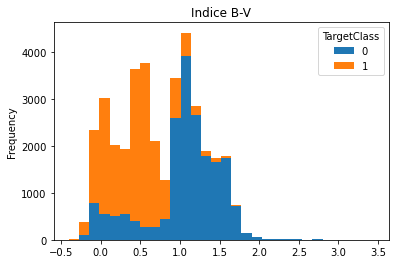

In [6]:
stars.pivot(columns="TargetClass")["B-V"].plot.hist(bins=30, stacked=True,title="Indice B-V");

Analizzando **l'indive B-V** si può notare che dopo una certa soglia aumentano le stelle Nane e diminuiscono le stelle giganti.

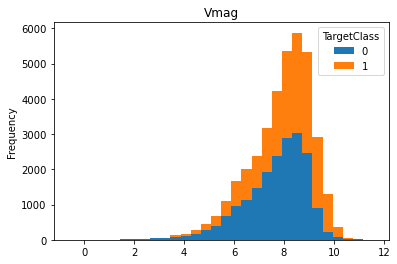

In [7]:
stars.pivot(columns="TargetClass")["Vmag"].plot.hist(bins=30, stacked=True,title="Vmag");

Visualizzando l'istogramma della **magnitudine apparente** della stella non si notano particolari relazioni con la tipologia della stella

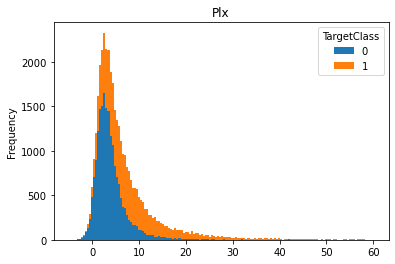

In [8]:
stars.pivot(columns="TargetClass")["Plx"].plot.hist(bins=150, stacked=True, range = (-5,60),title="Plx");

Visualizzando l'istogramma tra **la distanza della stella** e la terra si nota che all'aumentare della distanza diminuisce il numero di stelle nane in favore delle stelle giganti, questo comportamento potrebbe essere influenzato dal fatto che a grandi distanze è più difficile individuare le stelle nane rispetto alle stelle giganti ed utilizzando questi dati il modello di classificazione potrebbe risultare sbilanciato per classificare le stelle che verranno individuate lontane dalla terra. 

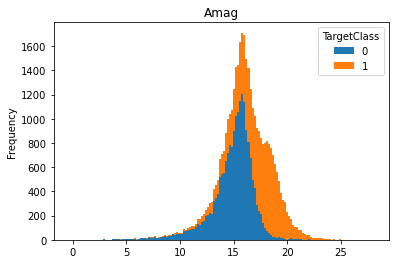

In [9]:
stars.pivot(columns="TargetClass")["Amag"].plot.hist(bins=150, stacked=True, title="Amag");

Infine analizzando la **magnitudine assoluta** della stella ottenuta combinando la magnitudine apparente e la distanza si può notare che all'aumentare della magnitudine assoluta aumentano le stelle giganti.

Infine visualizziamo il grafico a dispersione tra Magnitudine assoluta e indice B-V.
In arancione le giganti e in blu le nane.

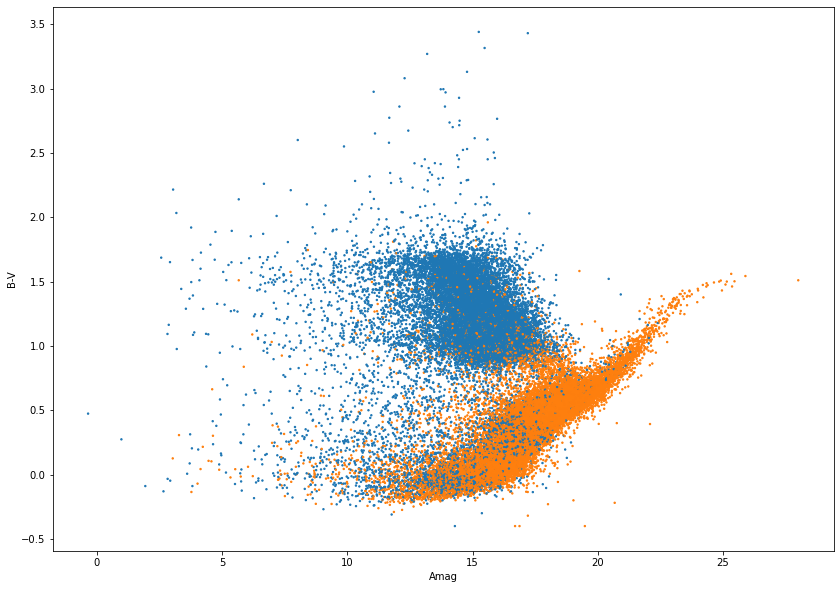

In [10]:
star_color_map = {0: "#1f77b4", 1: "#fe7f0e"}
star_colors = stars["TargetClass"].map(star_color_map)
stars.plot.scatter("Amag", "B-V", c=star_colors,figsize=(14,10), s=2);

# Individuazione delle feature più rilevanti

**suddividiamo i dati tra training e validation**


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

y = stars["TargetClass"]
X = stars.drop(columns = ["TargetClass", "SpType"])

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.3,    # 30% validation, 70% training
    random_state=61 
)

Proviamo a costruire un primo modello di classificazione basato sull'algoritmo **Perceptron**

In [12]:

from sklearn.linear_model import Perceptron
model = Perceptron(random_state=61)

model.fit(X_train, y_train)
model.score(X_val, y_val)

0.8761273209549072

Per individuare le feature più rilevanti, creiamo una pipeline che dopo aver effettuato la **standardizzazione**, utilizza un modello di classificazione **perceptron** applicando la **regolarizzazione con norma L1** e ne visualizziamo i pesi rilevati per ogni feature. 

In [13]:
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("scaler", StandardScaler()),
    ("perceptron",  Perceptron(penalty="l1", alpha=0.01))
])
model.fit(X_train,y_train)
model.score(X_val, y_val)

0.8760389036251105

In [14]:
pd.Series(model.named_steps["perceptron"].coef_[0],index=X.columns)

Vmag     0.000000
Plx      1.515038
e_Plx    0.000000
B-V     -1.866326
Amag     0.848336
dtype: float64

Possiamo notare che alle colonne **Vmag** e **e_Plx** è stato assegnato peso 0, in quanto non influiscono sulla classificazione della stella. 

Inoltre notiamo che il modello ha calcolato un grosso peso per la feature **Plx** ( distanza dalla terra ), in teoria non dovrebbe esserci una relazione tra la tipologia di una stella e la sua distanza dalla terra, ma come rilevato durante l'analisi esplorativa, questa relazione dovrebbe derivare dal fatto che il dataset comprende poche stelle nane a lunghe distanze, perchè essendo più piccole risulterebbero più difficili da individuare dalla terra.

Proviamo quindi ad addestrare un modello di classificazione basato sulle feature **Amag** ( magnitudine assoluta ) e **B-V** ( Indice di colore ).

In [43]:
y = stars["TargetClass"]
X = stars[["Amag", "B-V"]]

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.3,    # 30% validation, 70% training
    random_state=61 
)

In [44]:
perceptron_model = Pipeline([
    ("scaler", StandardScaler()),
    ("perceptron",  Perceptron())
])
perceptron_model.fit(X_train,y_train)
perceptron_model.score(X_val, y_val)

0.8579133510167993

Nonostante l'esclusione della feature Plx, la precisione del modello rimane accettabile.

Essendo il modello basato su sole due feature possiamo visualizzare la retta di separazione delle due classi.

In [45]:
def plot_separator_2d(X, y, *models):
    figure(figsize=(14, 10), dpi=80)
    X = np.array(X)
    colors = pd.Series(y).map(star_color_map)
    plt.scatter(X[:, 0], X[:, 1], c=colors, s=2)
    if len(models):
        xlim, ylim = plt.xlim(), plt.ylim()
        sep_x = np.linspace(*xlim, 2)
        for model in models:
            sep_y = -sep_x*model.coef_[0, 0]/model.coef_[0, 1] - model.intercept_[0] / model.coef_[0, 1]
            plt.plot(sep_x, sep_y, linewidth=2)#, c="green")
    
        plt.xlim(xlim); plt.ylim(ylim)

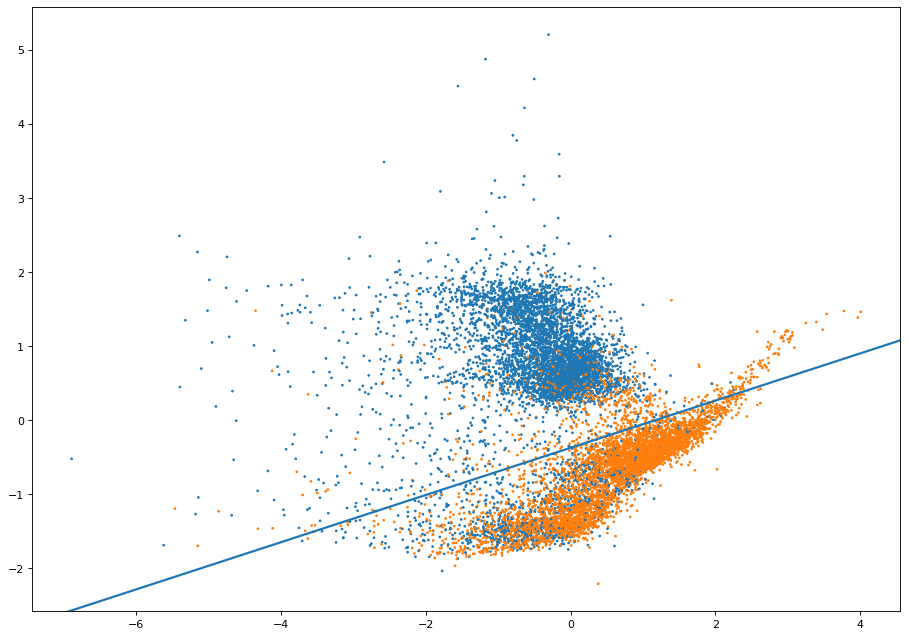

In [46]:
plot_separator_2d(
    perceptron_model.named_steps["scaler"].transform(X_val), 
    y_val, 
    perceptron_model.named_steps["perceptron"]
)

## Regressione Logistica

Sfruttando la **regressione logistica** possiamo creare un modello con maggiore precisione rispetto al metodo Perceptron.

Iniziamo creando un modello semplice e confrontiamolo con il perceptron

In [47]:
from sklearn.linear_model import LogisticRegression
log_reg_model = LogisticRegression(solver="saga", random_state=61) 
log_reg_model.fit(X_train, y_train)
log_reg_model.score(X_val, y_val)


0.8824933687002653

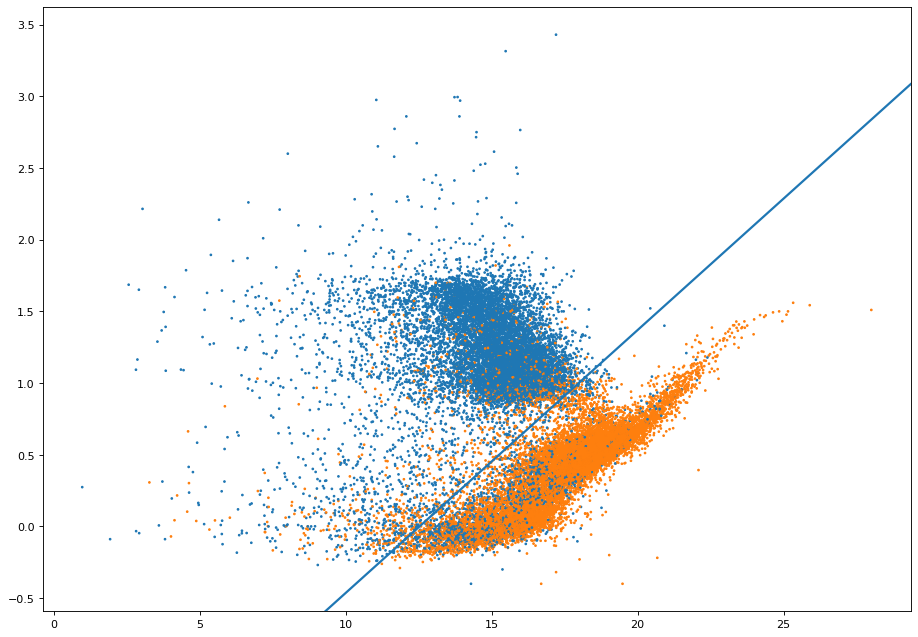

In [52]:
plot_separator_2d(X_train, y_train, log_reg_model)

Dal grafico e dallo score del modello di regressione logistica si nota un buon miglioramento rispetto al Perceptron.

### Individuazione dei migliori iperparametri per la regressione logistica 

Per migliorare il modello di Regressione logistica cerchiamo i migliori iperparametri utilizzando una **GridSearch** e una **Stratified Cross Validation**.

In [56]:
from sklearn.model_selection import StratifiedKFold
k=4
skf = StratifiedKFold(k, shuffle=True, random_state=61)

In [57]:
model = Pipeline([
    ("scaler", None),
    ("lr", LogisticRegression(solver="saga",random_state = 61))
])

In [58]:
from sklearn.model_selection import GridSearchCV

grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["none"]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2", "l1"],
        "lr__C": [0.1, 1, 10]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["elasticnet"],
        "lr__C": [0.1, 1, 10],
        "lr__l1_ratio": [0.1,0.3, 0.5,0.7, 0.9]
    }
]

In [59]:

gs = GridSearchCV(model, grid, cv=skf)

In [60]:
gs.fit(X_train, y_train);

In [61]:
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_lr__penalty,param_scaler,param_lr__C,param_lr__l1_ratio,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
16,0.115092,0.009993,0.001863,0.000036,elasticnet,None,0.1,0.3,"{'lr__C': 0.1, 'lr__l1_ratio': 0.3, 'lr__penal...",0.881310,0.883735,0.872669,0.884475,0.880547,0.004697,1
20,0.112339,0.007200,0.001866,0.000032,elasticnet,None,0.1,0.7,"{'lr__C': 0.1, 'lr__l1_ratio': 0.7, 'lr__penal...",0.881461,0.883583,0.872821,0.884324,0.880547,0.004583,2
6,0.129794,0.046201,0.002332,0.000842,l2,None,1,NaN,"{'lr__C': 1, 'lr__penalty': 'l2', 'scaler': None}",0.881461,0.883432,0.872973,0.884324,0.880547,0.004494,3
22,0.111113,0.008395,0.001866,0.000037,elasticnet,None,0.1,0.9,"{'lr__C': 0.1, 'lr__l1_ratio': 0.9, 'lr__penal...",0.881461,0.883432,0.872821,0.884324,0.880509,0.004558,4
18,0.118294,0.013087,0.002010,0.000256,elasticnet,None,0.1,0.5,"{'lr__C': 0.1, 'lr__l1_ratio': 0.5, 'lr__penal...",0.881310,0.883583,0.872821,0.884324,0.880509,0.004576,4


In [62]:
gs.best_params_

{'lr__C': 0.1,
 'lr__l1_ratio': 0.3,
 'lr__penalty': 'elasticnet',
 'scaler': None}

La **GridSearch** ha individuato come modello migliore secondo la **cross-validation** il modello di regressione logistica senza standardizzazione con regolarizzazione **elasticnet** con rapporto l1 pari al 30% e C pari a 0.1.

Proviamo ora a cercare i migliori iperparametri tramite **RandomSearch**

In [63]:
from sklearn.model_selection import RandomizedSearchCV

random_grid = [
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["none"]
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["l2", "l1"],
        "lr__C": np.logspace(-2, 2, num=50),
    },
    {
        "scaler": [None, StandardScaler()],
        "lr__penalty": ["elasticnet"],
        "lr__C": np.logspace(-2, 2, num=50),
        "lr__l1_ratio": np.linspace(0, 1, num=20),
    }
]

rs = RandomizedSearchCV(model,random_grid, random_state=61,  cv=skf)
rs.fit(X_train, y_train);
pd.DataFrame(rs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_scaler,param_lr__penalty,param_lr__l1_ratio,param_lr__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
7,0.118069,0.015309,0.001906,0.000004,None,elasticnet,0.421053,0.13895,"{'scaler': None, 'lr__penalty': 'elasticnet', ...",0.881461,0.883583,0.872821,0.884324,0.880547,0.004583,1
2,0.028685,0.001105,0.002123,0.000174,StandardScaler(),elasticnet,0.210526,100,"{'scaler': StandardScaler(), 'lr__penalty': 'e...",0.881461,0.883583,0.872821,0.884172,0.880509,0.004552,2
3,0.040832,0.011507,0.003054,0.001032,StandardScaler(),elasticnet,0.894737,0.910298,"{'scaler': StandardScaler(), 'lr__penalty': 'e...",0.881461,0.883583,0.872821,0.884172,0.880509,0.004552,2
4,0.048970,0.019188,0.002373,0.000279,StandardScaler(),elasticnet,0.315789,0.754312,"{'scaler': StandardScaler(), 'lr__penalty': 'e...",0.881461,0.883583,0.872821,0.884172,0.880509,0.004552,2
8,0.027075,0.001975,0.001953,0.000016,StandardScaler(),elasticnet,0.842105,100,"{'scaler': StandardScaler(), 'lr__penalty': 'e...",0.881461,0.883583,0.872821,0.884172,0.880509,0.004552,2


In [64]:
rs.best_params_

{'scaler': None,
 'lr__penalty': 'elasticnet',
 'lr__l1_ratio': 0.42105263157894735,
 'lr__C': 0.13894954943731375}

La **RandomSearch**  ha individuato come modello migliore secondo la **cross-validation** il modello di regressione logistica senza standardizzazione e con regolarizzazione **elasticnet** con rapporto l1 pari al 42% e C pari a 0.14, valori simili al risultato ottenuto dalla GridSearch.

Proviamo a visualizzare l'accuratezza dei due modelli sul validation set.



In [65]:
gs.best_estimator_.score(X_val, y_val)

0.8821396993810787

In [66]:
rs.best_estimator_.score(X_val, y_val)

0.8822281167108753

Risulta essere leggermente più accurato il modello con gli iperparametri individuati dalla RandomSearch, visualizziamone il grafico :

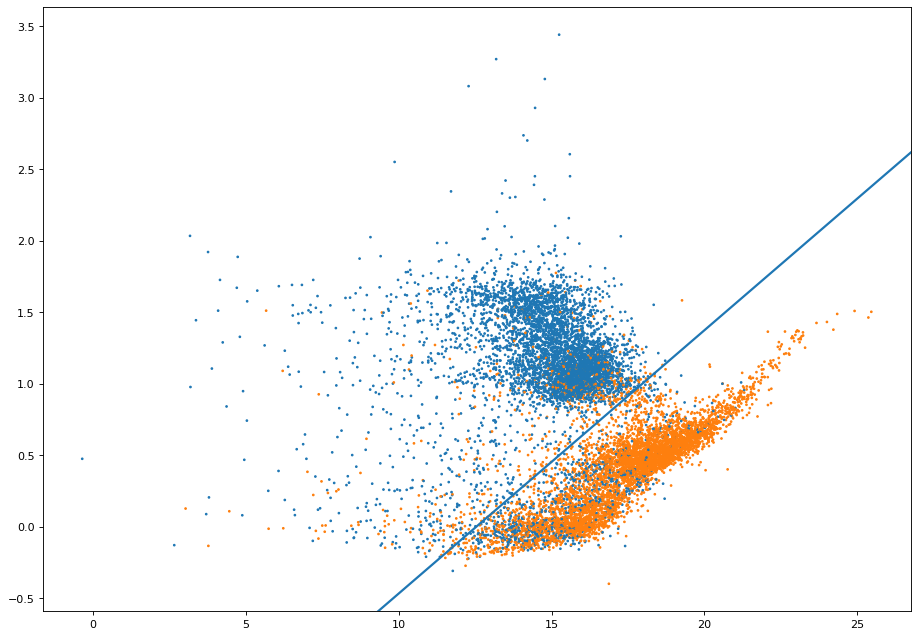

In [67]:
plot_separator_2d(
    X_val,
    y_val, 
    rs.best_estimator_.named_steps["lr"]
)

## Classificazione mediante alberi decisionali

Proviamo ora a generare un semplice modello di classificazione basasto sugli alberi decisionali con profondità limitata a 3

In [68]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier(max_depth=3, random_state=61)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=61)

Visualizziamo ora l'albero decisionale generato dal modello di profondità pari a 3.

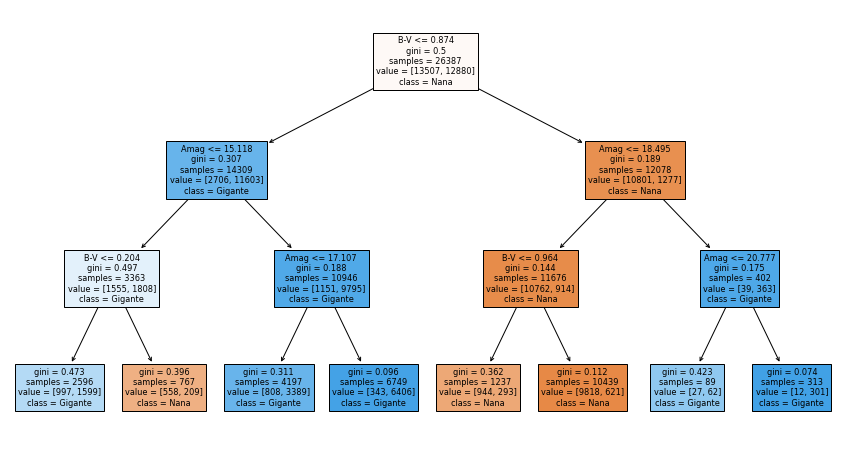

In [69]:
from sklearn.tree import plot_tree
plt.figure(figsize=(15, 8))
plot_tree(model, feature_names=X.columns.to_list(),filled=True,class_names=['Nana','Gigante']);


In [35]:
model.score(X_val,y_val)

0.8756852343059239

L'accuratezza del modello ed è ottima, paragonabile ai modelli di regressione logistica precedentemente individuati

Cerchiamo di migliorare il risultato, individuando gli iperparametri migliori tramite **GridSearch** e **RandomSearch**

In [70]:
model = DecisionTreeClassifier(random_state=61)
grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 50, 100]
}
gs = GridSearchCV(model, grid, cv=skf)
gs.fit(X_train, y_train)
pd.DataFrame(gs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
4,0.018935,0.000099,0.001972,0.000047,5,50,"{'max_depth': 5, 'min_samples_split': 50}",0.881158,0.880097,0.869789,0.882353,0.878349,0.005006,1
3,0.019069,0.000096,0.001993,0.000024,5,2,"{'max_depth': 5, 'min_samples_split': 2}",0.881158,0.879794,0.869789,0.882353,0.878274,0.004981,2
5,0.018893,0.000085,0.001944,0.000029,5,100,"{'max_depth': 5, 'min_samples_split': 100}",0.881310,0.879491,0.869941,0.882050,0.878198,0.004857,3
0,0.017141,0.003053,0.002780,0.000527,3,2,"{'max_depth': 3, 'min_samples_split': 2}",0.875549,0.876611,0.865848,0.876592,0.873650,0.004525,4
1,0.012959,0.000163,0.001921,0.000032,3,50,"{'max_depth': 3, 'min_samples_split': 50}",0.875549,0.876611,0.865848,0.876592,0.873650,0.004525,4


In [71]:
gs.best_params_

{'max_depth': 5, 'min_samples_split': 50}

Gli iperparametri migliori trovato dalla GridSearch risultano, **profondità massima** pari a 5 e **numero minimo di casi di training in un noto intermedio** pari a 50

In [82]:
random_grid = {
    "max_depth": np.arange(0,30),
    "min_samples_split": np.arange(0,100),
}
rs = RandomizedSearchCV(model, random_grid, random_state=61, cv=skf)
rs.fit(X_train, y_train)
pd.DataFrame(rs.cv_results_).sort_values("rank_test_score").head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,mean_test_score,std_test_score,rank_test_score
7,0.016275,0.000069,0.001962,0.000008,71,4,"{'min_samples_split': 71, 'max_depth': 4}",0.880552,0.877975,0.870850,0.881140,0.877629,0.004091,1
9,0.024361,0.000319,0.002103,0.000034,78,7,"{'min_samples_split': 78, 'max_depth': 7}",0.878733,0.881461,0.870244,0.879927,0.877591,0.004351,2
8,0.012825,0.000147,0.001923,0.000035,4,3,"{'min_samples_split': 4, 'max_depth': 3}",0.875549,0.876611,0.865848,0.876592,0.873650,0.004525,3
5,0.033908,0.000362,0.002369,0.000067,97,11,"{'min_samples_split': 97, 'max_depth': 11}",0.874943,0.876459,0.862665,0.874773,0.872210,0.005550,4
6,0.034696,0.000685,0.002378,0.000062,35,11,"{'min_samples_split': 35, 'max_depth': 11}",0.870850,0.871608,0.858724,0.870831,0.868003,0.005367,5


In [83]:
rs.best_params_

{'min_samples_split': 71, 'max_depth': 4}

Gli iperparametri migliori trovato dalla GridSearch risultano, **profondità massima** pari a 4 e **numero minimo di casi di training in un noto intermedio** pari a 71

Valutiamo l'accuratezza dei due modelli sul dataset di validazione.

In [84]:
gs.best_estimator_.score(X_val, y_val)

0.8800176834659593

In [85]:
rs.best_estimator_.score(X_val, y_val)

0.8781609195402299

Il modello trovato dalla GridSearch risulta leggermente più accurato, visualizziamo l'albero decisionale:

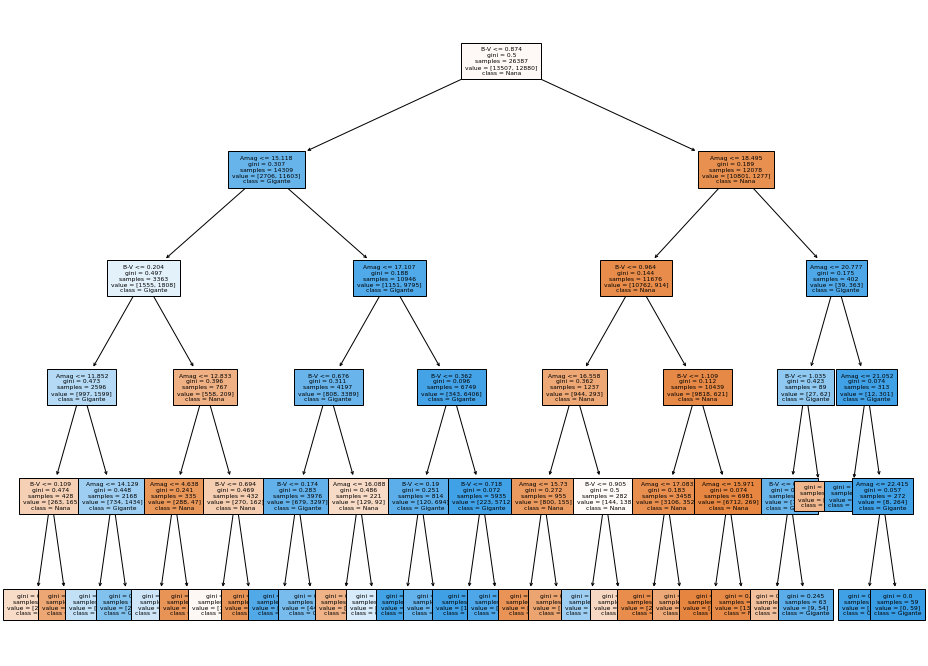

In [86]:

plt.figure(figsize=(16, 12))
plot_tree(gs.best_estimator_, feature_names=X.columns.to_list(),filled=True,class_names=['Nana','Gigante'], fontsize=6);


### Conclusioni

Dopo aver generato diversi modelli di classificazione basati su diverse tecniche, siamo riusciti ad ottenere risultati paragonabili tra i modelli di regressione logistica e gli alberi decisionali.
In entrambi i casi il risultato ottenuto ha accuratezza R² ≈ 0.88.

Siccome è stato escluso l'attributo "distanza dalla terra", i modelli saranno indipendenti dalla precisione dei telescopi utilizzati per inidividuare le stelle.